In [1]:
import cv2
from ipywidgets import *
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy.stats as stats
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data, io, img_as_ubyte, transform
from skimage.color import rgb2gray, rgba2rgb

In [2]:
def bin_img(url):
    img = io.imread(url)
    if img.shape[2] == 4:
        img = rgba2rgb(img)
    img = 1-rgb2gray(img)
    return img > 0

def plot_moments(moment="m00", centroid=False):  
    plt.figure(figsize=(10,10))
    for i, im in enumerate(figs):
        img = img_as_ubyte(im)
        contours, _ = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        moments = cv2.moments(contours[0])
        if centroid:
            cX = int(moments["m10"] / moments["m00"])
            cY = int(moments["m01"] / moments["m00"])
            cv2.circle(img, (cX, cY), 10, (0, 0, 0), -1)
        plt.subplot(2,2,i+1);
        plt.title(moment+ ": "+str(moments[moment]))
        plt.imshow(img, cmap='gray')

def heatmap(data, labels, ax, colormap="Wistia", c="b", title=""):   
    im = ax.imshow(data, cmap=colormap)
    n = len(labels)
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, data[i, j], ha="center", va="center", color=c, size='x-large')
        
    if title != "":
        ax.set_title(title)

def hu_dist():
    contours = [contour for contour, h in [cv2.findContours(img_as_ubyte(img),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) for img in figs]]
    n = len(contours)
    dists = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            dists[i][j] = round(cv2.matchShapes(contours[i][0],contours[j][0],cv2.CONTOURS_MATCH_I2,0),3)

    fig, ax = plt.subplots(figsize=(6,6))
    heatmap(dists, ["star", "star_t", "star_sr", "heart"], ax)
            
def confusion_matrix(thresh = 105):
    mu1 = 100
    mu2= 120
    sigma = 7
    xs = [np.linspace(m-3.5*sigma, m+3.5*sigma, 100) for m in [mu1, mu2]]
    fig, axs= plt.subplots(1, 2, figsize=(15,5))

    for x, m in zip(xs,[mu1, mu2]):
        y = stats.norm.pdf(x, m, sigma)
        axs[0].plot(x, y)
        axs[0].fill_between(x, y, alpha=0.5)
    axs[0].axvline(x=thresh, c='k')
    
    positive = np.random.normal(mu2, sigma, 50)
    negative = np.random.normal(mu1, sigma, 50)
    
    mat = np.zeros((2,2), dtype=np.long)
    mat[0,0] = sum(positive >= thresh)
    mat[0,1] = sum(negative >= thresh)
    mat[1,0] = sum(positive < thresh)
    mat[1,1] = sum(negative < thresh)
    accuracy = (mat[0,0] + mat[1,1])/np.sum(mat)
    
    heatmap(mat, ['positive', 'negative'], axs[1], colormap="YlGn", c="r", title="accuracy: "+str(accuracy))


img = bin_img("https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Full_star.svg/480px-Full_star.svg.png") 
img2 = bin_img("https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Love_Heart_symbol_inglow.svg/521px-Love_Heart_symbol_inglow.svg.png") 

padding = 200
star = np.pad(img, ((padding, padding), (padding, padding)), 'constant', constant_values=(0, 0))
star2 = np.pad(img, ((0, padding*2), (0, padding*2)), 'constant', constant_values=(0, 0))
star3 = np.pad(transform.rescale(transform.rotate(star,45), 0.5), ((0, padding*2), (0, padding*2)), 'constant', constant_values=(0, 0))
heart = np.pad(img2, ((padding, padding), (padding, padding)), 'constant', constant_values=(0, 0))

figs = [star, star2, star3, heart]

### Transformacja Hougha

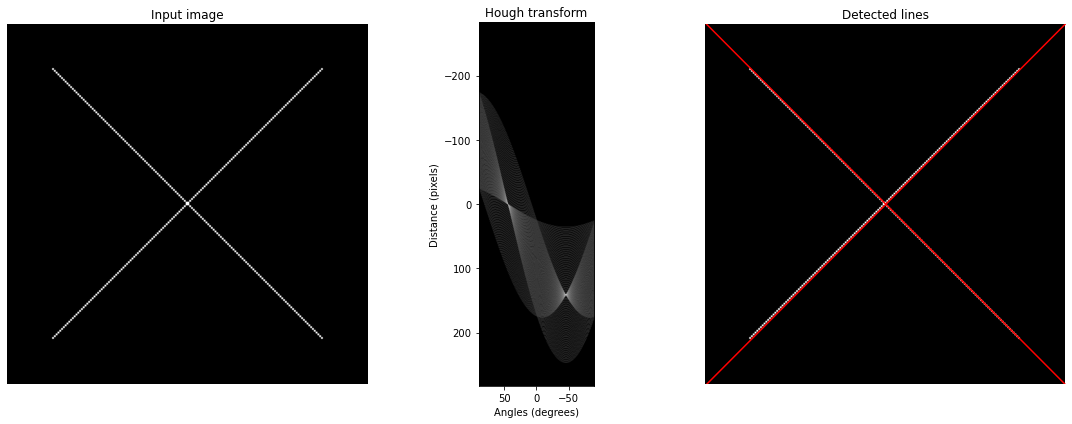

In [3]:
#https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html

# Constructing test image
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

### Momenty

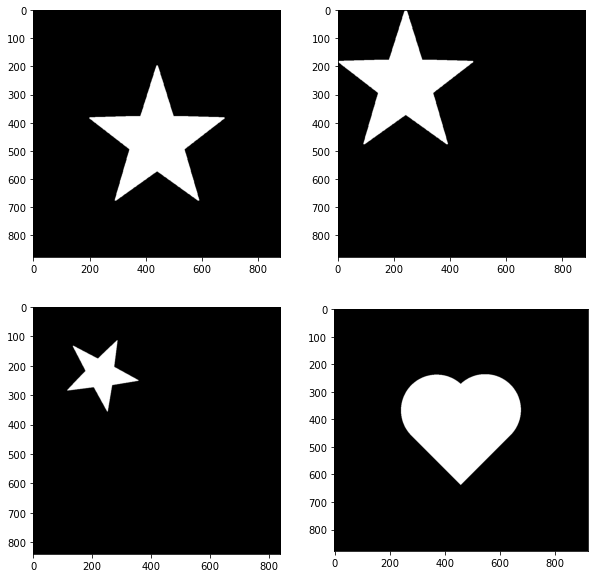

In [5]:
plt.figure(figsize=(10,10))
for i, s in enumerate(figs):
    plt.subplot(2,2,i+1);
    plt.imshow(s, cmap='gray')    

#### Moment zwykły

$$M_{ij} = \sum_{x}\sum_{y}x^iy^jI(x,y)$$

$${\textrm{Centroid: }\displaystyle \{{\bar {x}},\ {\bar {y}}\}=\left\{{\frac {M_{10}}{M_{00}}},{\frac {M_{01}}{M_{00}}}\right\}}$$

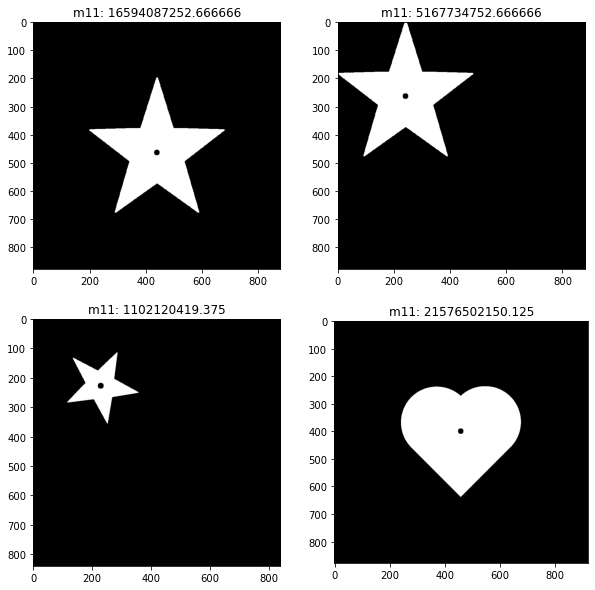

In [6]:
plot_moments("m11", centroid=True)

#### Moment centralny

$$\mu_{ij} = \sum_{x}\sum_{y}(x-\bar{x})^i(y-\bar{y})^jI(x,y)$$

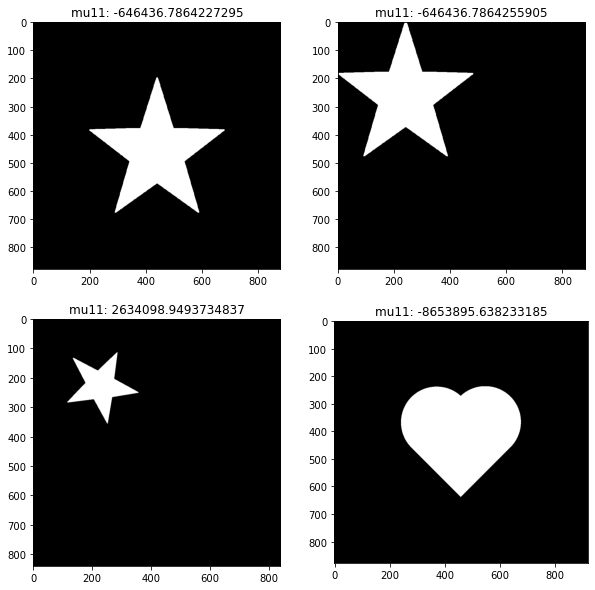

In [7]:
plot_moments("mu11")

#### Moment centralny znormalizowany

$$\eta_{ij} = \frac{\mu_{ij}}{\mu_{00}^{\left(1+\frac{i+j}{2}\right)}}\textrm{,}$$
gdzie $i + j \geq 2$

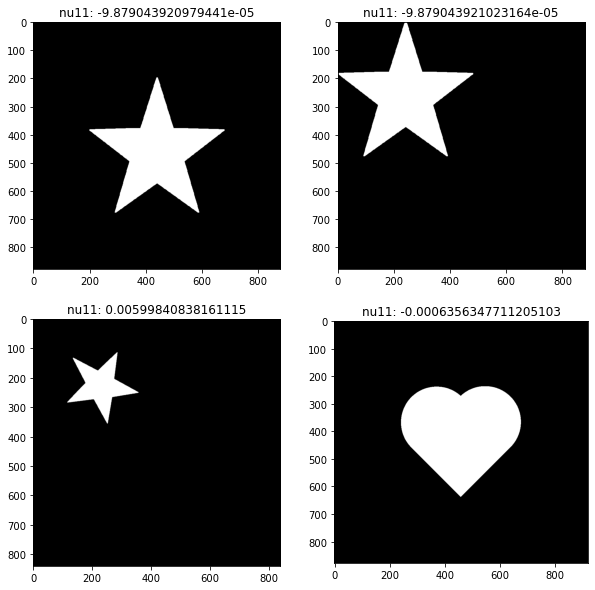

In [8]:
plot_moments("nu11")

#### Momenty Hu

$I_{1}=\eta _{{20}}+\eta _{{02}}$

$I_{2}=(\eta _{{20}}-\eta _{{02}})^{2}+4\eta _{{11}}^{2}$

$I_{3}=(\eta _{{30}}-3\eta _{{12}})^{2}+(3\eta _{{21}}-\eta _{{03}})^{2}$

$I_{4}=(\eta _{{30}}+\eta _{{12}})^{2}+(\eta _{{21}}+\eta _{{03}})^{2}$

$I_{5}=(\eta _{{30}}-3\eta _{{12}})(\eta _{{30}}+\eta _{{12}})[(\eta _{{30}}+\eta _{{12}})^{2}-3(\eta _{{21}}+\eta _{{03}})^{2}]+(3\eta _{{21}}-\eta _{{03}})(\eta _{{21}}+\eta _{{03}})[3(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]$

$I_{6}=(\eta _{{20}}-\eta _{{02}})[(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]+4\eta _{{11}}(\eta _{{30}}+\eta _{{12}})(\eta _{{21}}+\eta _{{03}})$

$I_{7}=(3\eta _{{21}}-\eta _{{03}})(\eta _{{30}}+\eta _{{12}})[(\eta _{{30}}+\eta _{{12}})^{2}-3(\eta _{{21}}+\eta _{{03}})^{2}]-(\eta _{{30}}-3\eta _{{12}})(\eta _{{21}}+\eta _{{03}})[3(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]$


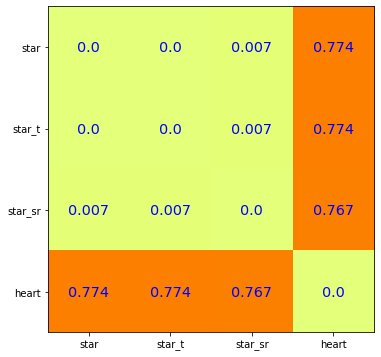

In [9]:
hu_dist()

### kNN

![knn](https://docs.opencv.org/master/knn_simple.png)

[https://docs.opencv.org/master/d5/d26/tutorial_py_knn_understanding.html](https://docs.opencv.org/master/d5/d26/tutorial_py_knn_understanding.html)

### Tradycyjny algorytm

![pipeline](https://www.learnopencv.com/wp-content/uploads/2016/11/image-classification-pipeline-1024x372.jpg)

[https://www.learnopencv.com/image-recognition-and-object-detection-part1](https://www.learnopencv.com/image-recognition-and-object-detection-part1/)

### Sieci neuronowe

![nn](https://cs231n.github.io/assets/nn1/neural_net.jpeg)

[https://cs231n.github.io/neural-networks-1/](https://cs231n.github.io/neural-networks-1/)

![convnet](https://cs231n.github.io/assets/cnn/convnet.jpeg)

[https://cs231n.github.io/convolutional-networks](https://cs231n.github.io/convolutional-networks/)

### Macierz pomyłek

<table>
<tbody><tr>
<td>
<table style="border:none; float:left; margin-top:0;">
<tbody><tr>
<th style="background:white; border:none;" colspan="2" rowspan="2">
</th>
<th colspan="2" style="background:none;">Klasa rzeczywista
</th></tr>
<tr>
<th>pozytywna
</th>
<th>negatywna
</th></tr>
<tr>
<th rowspan="2" style="height:6em;">Klasa<br />przewidziana
</th>
<th>pozytywna
</th>
<td>prawdziwie<br />pozytywna (TP)
</td>
<td>fałszywie<br />pozytywna (FP)
</td></tr>
<tr>
<th>negatywna
</th>
<td>fałszywie<br />negatywna (FN)
</td>
<td>prawdziwie<br />negatywna (TN)
</td></tr></tbody></table>
</td></tr></tbody></table>

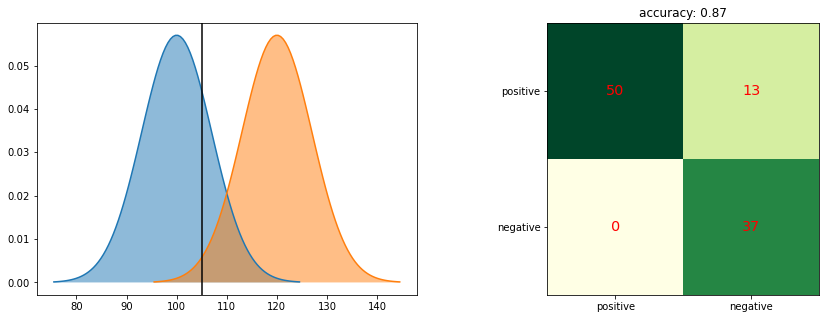

<function __main__.confusion_matrix(thresh=105)>

In [10]:
interact(confusion_matrix, thresh=(80,140,1))